In [24]:
from gensim.parsing.preprocessing import stem_text
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models 
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
sys.path.append('../')
from utils import word_frequency_per_player, remove_similar_rows_per_player
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import pyLDAvis
from pyLDAvis.gensim_models import prepare
import re
from seaborn import countplot, distplot, heatmap, histplot
import numpy as np
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords



# Load data and convert to stemmed data 

In [104]:
# load data and drop NA's
df = pd.read_csv('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/TWSM/TWSM Project/SS23-BIPM-Analytics-Lab---Group-4-repository/Preprocessing/data_clean/de_clean_condensed.csv')

## Wordcloud
Build a wordcloud in order to see words which could be deleted for clustering
Because some words appear in every cluster they need to be deleted

In [105]:
stopwords = {"bayerleverkusen", "leverkusen", "nicht", "uber", "geht", "hat", "sein", "konnte", "ein", "gibt", "ist"}

# Apply the remove_stopwords function to the 'text' column using the apply method
df['data'] = df['data'].apply(lambda x: remove_stopwords(x, stopwords))

/opt/homebrew/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


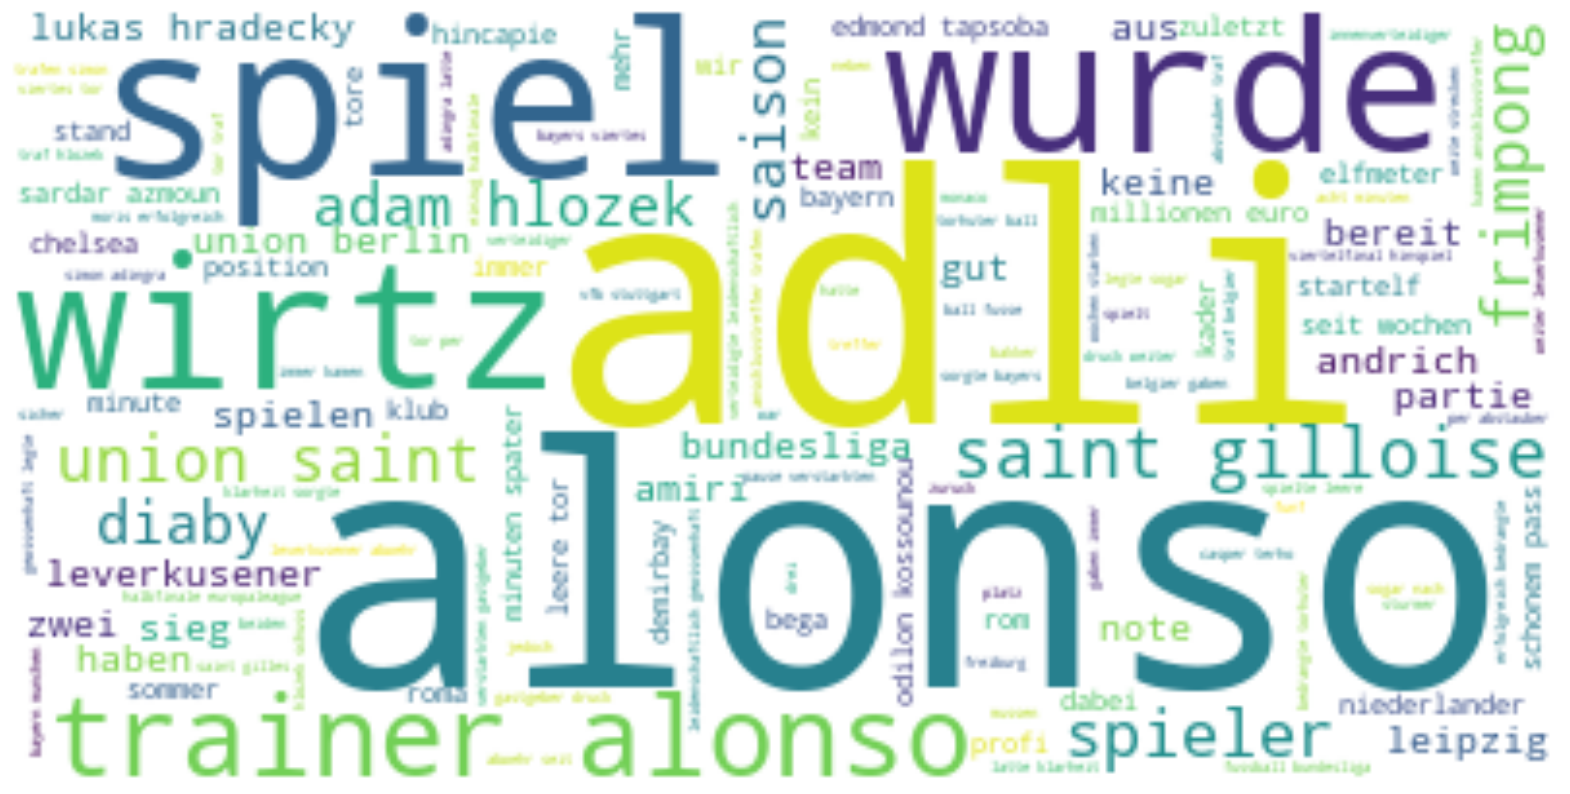

In [106]:
# store the complete text in all_text
all_text = df['data'].str.cat(sep=' ')

# create a plot
plt.figure(figsize=(20,20))

# create a wordcloud
wordcloud = WordCloud( background_color="white").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Stemming

In [107]:
# create two copies 
df_stem = df.copy()

# create stemmed data
df_stem['data'] = df_stem['data'].apply(stem_text)

df_stem

,data,player,language,publishedAt
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z
...,...,...,...,...
605,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z
606,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z
607,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z
608,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z


In [108]:
# Remove the similiar rows (The Function is imported from utils on top)
df_stem = remove_similar_rows_per_player(df_stem, df_stem['player'].unique())

In [109]:
# vectorize data 
tfidf = TfidfVectorizer(max_df=0.95, min_df=0.02)
df_tfidf = tfidf.fit_transform(df_stem.data).toarray()

In [110]:
df_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
#Store the frequency matrix in data_tfidf. 
data_tfidf = pd.DataFrame(df_tfidf, columns=tfidf.vocabulary_.keys())

#data_tfidf['target_names']=sorted_df_ng.target_names.values #we can't use that because otherwise knn wouldn't work
data_tfidf.head()

,trainer,alonso,fan,monaco,tor,sechser,droht,paus,dafur,lang,...,reih,freistehend,end,bedient,zog,winter,doppelpass,verwertet,halbchancen,lautstark
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.299362,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
#Store the feature names in a words list.
words = data_tfidf.columns.tolist()[:-2] 
words

['trainer',
 'alonso',
 'fan',
 'monaco',
 'tor',
 'sechser',
 'droht',
 'paus',
 'dafur',
 'lang',
 'zudem',
 'seit',
 'woch',
 'amiri',
 'demirbai',
 'andrich',
 'erklart',
 'budapest',
 'spiel',
 'donnerstag',
 'hinspiel',
 'europaleagu',
 'sah',
 'defens',
 'mittelfeldspiel',
 'erfolg',
 'dritt',
 'gelb',
 'kart',
 'gesperrt',
 'werkself',
 'zuletzt',
 'bakker',
 'abschluss',
 'jedoch',
 'startelf',
 'steht',
 'mittelfeld',
 'sech',
 'muss',
 'stehen',
 'bereit',
 'allerd',
 'argentinischen',
 'weltmeist',
 'beid',
 'eigentlich',
 'verletzt',
 'zumindest',
 'union',
 'berlin',
 'chancen',
 'deutlich',
 'saint',
 'gillois',
 'alten',
 'erneut',
 'schwer',
 'kamen',
 'zuschauern',
 'minut',
 'gast',
 'fuhrung',
 'fussbal',
 'bundesligisten',
 'gut',
 'borussia',
 'dortmund',
 'entscheidenden',
 'moment',
 'gab',
 'bundesliga',
 'zuruck',
 'spielen',
 'weit',
 'auf',
 'platz',
 'sagt',
 'zweiten',
 'halft',
 'bisschen',
 'gefahrlich',
 'sind',
 'bracht',
 'diesmal',
 'grossen',
 'sehr

# KMeans clustering approach

In [113]:
kmeans = KMeans(n_clusters = 4, max_iter=1000, random_state=42)
kmeans.fit(data_tfidf)

/opt/homebrew/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=1000, n_clusters=4, random_state=42)

In [114]:
# store the common words for each cluster
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

In [115]:
for num, centroid in enumerate(common_words):
    words_in_centroid = [words[word] for word in centroid if word < len(words)]
    print(f"{num}: {', '.join(words_in_centroid)}")
# By adding the if word < len(words) condition, we ensure that only valid indices are used to access the words list or dictionary.

0: amiri, platz, kommenden, marvin, sardar, reicht, dortmund, bellarabi, union, entscheidung
1: besser, linken, gillois, leistungen, starker, sech, marvin, stuttgart, verzog, hinten
2: spiel, pass, millionen, versuch, sieg, vergangenen, endspiel, jona, grossen, defens
3: rote, gesetzt, leistungen, rannten, spanier, korperlichkeit, starker, nehmen, marvin, edmond


In [116]:
# create copy of original dataframe
df_kmeans = df_stem.copy()

In [117]:
df_kmeans['cluster'] = kmeans.labels_
df_kmeans

,data,player,language,publishedAt,cluster
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,2
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,2
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,2
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,2
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,2
...,...,...,...,...,...
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,3
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,3
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,3
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,3


In [118]:
clusters = df_kmeans.groupby(['cluster']).size()
clusters

cluster
0    184
1     59
2    224
3    130
dtype: int64

## Try out different cluster sizes

In [ ]:
# create list where the models will be stored
kmeans_models_arr = {'cluster_' + str(iter): '' for iter in range(2, 15)}

# create models with 2-15 clusters
for iter in range(2, 15): 
    
    model = KMeans(n_clusters = iter, max_iter=1000, random_state=42)
    model.fit(data_tfidf)

    kmeans_models_arr.update({'cluster_'+ str(iter): model})


In [120]:
# store the common words for each cluster
common_words = kmeans_models_arr['cluster_8'].cluster_centers_.argsort()[:,-1:-31:-1]

for num, centroid in enumerate(common_words):
    words_in_centroid = [words[word] for word in centroid if word < len(words)]
    print(f"{num}: {', '.join(words_in_centroid[:30])}")

0: rannten, korperlichkeit, spanier, samstag, moment, schlug, spiel, vollendet, konter, defens, endspiel, naturlich, gemacht, fan, nehmen, ubernahm, millionen, leistung, pass, kampf, aktuel, stieler, reicht, per, rote, edmond, ruckstand, frankfurt, spielen, arbeit
1: dortmund, abseit, platz, letzten, millionen, deutlich, verteidig, mitt, winter, lasst, worden, viel, erstmal, tor, sowi, da, wurden, traumen, dritten, gast, rettet, budapest, insgesamt, sturmer, fuhrung, wahrend, mannschaft, star, freistoss, gladbach
2: besser, leistungen, gillois, linken, sech, marvin, paar, meist, internationalen, problem, schlusspfiff, euro, stuttgart, abraham, muss, bisschen, duell, verzog, hinten, wirtz, schliesslich, adli, zuruck, mai, verteidigt, woch, hradecki, trotzdem, naturlich, belgischen
3: spiel, millionen, pass, defens, versuch, angriff, hinspiel, drei, sonntag, patricio, endspiel, freistoss, jung, spater, schlusspfiff, verrichten, gar, jona, mussen, leagu, strafstoss, jahren, tapsoba, platz

## Cluster naming
0 = Europa League
___
1 = Bundesliga news
___
2 = Europa League
___
3 = Game Situations and Match Performance
___
4 = Europa League
___
5 = Game Situations and Match Performance
___
6 = Bundesliga News
___
7 = Europa League

In [121]:
# assign cluster to dataframe
df_kmeans['cluster'] = kmeans_models_arr['cluster_8'].labels_
df_kmeans

,data,player,language,publishedAt,cluster
0,trainer alonso mitgereisten fan monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,3
1,sechser droht viereinhalb monaten paus bitter abschi dafur erscheint verletzungspaus lang zudem konkurrenzsitu doppelsech seit woch voll saft stehenden amiri demirbai andrich voraussetzungen extrem schwierig aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,3
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfin hinspiel europaleagu ferencvaro budapest empfangt andrich fehlen sah defens mittelfeldspiel erfolg elfmeterschiessen monaco dritt gelb kart gesperrt massiv schwachung werkself doppelsech andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,3
3,bakker mittwoch abschluss train ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sech verzichten muss andrich gesperrt stehen demirbai amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,3
4,allerd andrich argentinischen weltmeist beid eigentlich gesetzten sechser gesperrt charl aranguiz zudem verletzt donnerstag machten sach zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,3
...,...,...,...,...,...
77,wehrt europaleagu lang gut schwere hypothek ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,0
78,alonso taktik duell alten lehrmeist mourinho niederlag einstecken mussen droht einzug endspiel europaleagu verpassen halbfin hinspiel rom steht alonso trainiert werkself ruckspiel woch ganz schweren aufgab dritt europacup final vereinsgeschicht erreichen titel seit traumen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,0
79,trotz pleit halbfin hinspiel rom kampferisch luka hradecki knapp pleit kein katastroph zudem setzt kapitan hexenkessel eigenen stadion trainer alonso optimistisch ruckspiel romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,0
80,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeist arm erst taktik duell ging mourinho droht alonso einzug endspiel europaleagu verpassen romischen fan lautstark hymn choreo rang knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigt unbeeindruckt beinah blitzstart hingelegt sekunden gespielt andrich hereingab etwa zwolf metern schuss kam zentral halbhoch sodass portugiesisch torhut rui patricio seit donnerstag einsatzen rekordspiel europaleagu wenig muhe hatt chancenlo ware portugiesisch europameist sechsten minut gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,0


In [122]:
# map the clusters to topics
def map_cluster_topic(cluster):
    if cluster == 3 or cluster == 5:
        return 'Game Situations and Match Performance'
    elif cluster == 1 or cluster == 6 :
        return 'Bundesliga News'
    elif cluster == 0 or cluster == 2 or cluster == 4 or cluster ==7:
        return 'Europa League'


# Apply the function and create 'sentiment_tb_desc' column
df_kmeans['topic'] = np.vectorize(map_cluster_topic)(df_kmeans['cluster'])

In [123]:
df_kmeans.to_csv('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/TWSM/TWSM Project/SS23-BIPM-Analytics-Lab---Group-4-repository/Modeling/modeled_data/clustered_data_kmeans_ger_v2.csv', index=False)

In [125]:
# store the model in a pickle file 
with open('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/TWSM/TWSM Project/SS23-BIPM-Analytics-Lab---Group-4-repository/Modeling/models/de_final_topic_model.pkl', 'wb') as file:
    pickle.dump(kmeans_models_arr['cluster_8'], file)

## Examining cluster dirstribution and prediction probabilities for clusters clusters

In [88]:
clusters = df_kmeans.groupby(['cluster']).size()
clusters

cluster
0     57
1     19
2     41
3    137
4     42
5    124
6    146
7     31
dtype: int64

In [91]:
# Compute the distances to the cluster centroids
distances = kmeans_models_arr['cluster_8'].transform(data_tfidf)

# Calculate cluster membership probabilities
membership_probs = np.exp(-distances) / np.sum(np.exp(-distances), axis=1, keepdims=True)

# Print the membership probabilities for each data point
print(membership_probs)

[[0.12899175 0.11536621 0.11530469 ... 0.1311489  0.13192106 0.11896967]
 [0.12881786 0.11047435 0.11569497 ... 0.13065358 0.13204598 0.11968654]
 [0.13062921 0.11234198 0.11201346 ... 0.12817373 0.1328675  0.11958628]
 ...
 [0.14509984 0.10830741 0.11507747 ... 0.13094518 0.12986454 0.1156231 ]
 [0.14392212 0.10840649 0.11447694 ... 0.13043067 0.12984573 0.11621928]
 [0.14726143 0.10739047 0.11678053 ... 0.12817449 0.12859121 0.11482917]]


In [92]:
membership_probs[1]

array([0.12881786, 0.11047435, 0.11569497, 0.13679406, 0.12583266,
       0.13065358, 0.13204598, 0.11968654])

Examinge the probability of a row lying in a cluster we can see that the propabilities are all close to each other. 

# Please remark the clustering Part until this Point represents our choosen model
The following exploration of LDA topic modeling is represented for further deleopement the model we choose is the KMeans cluster model with 8 clusters above

# LDA Model

In [20]:
# Split the texts into a list of words
texts = [text.split() for text in df_stem['data']]

# Create the Gensim dictionary
dictionary = corpora.Dictionary(texts)

# Remove rare and common words from the dictionary
dictionary.filter_extremes(no_below=118, no_above=0.95)

# Derive the absolute frequency matrix using doc2bow
corpus = [dictionary.doc2bow(text) for text in texts]


In [21]:
# create one lda model with 4 clusters
lda = models.LdaModel(corpus, num_topics=4, id2word=dictionary, chunksize=10, iterations=100, passes=10, random_state=42)

In [22]:
# show topics of the lda model
lda.show_topics()

[(0,
  '0.542*"alonso" + 0.454*"trainer" + 0.001*"wirtz" + 0.001*"leverkusen" + 0.001*"frimpong" + 0.001*"ball" + 0.001*"diabi" + 0.001*"europaleagu" + 0.001*"spiel"'),
 (1,
  '0.984*"spiel" + 0.002*"wirtz" + 0.002*"leverkusen" + 0.002*"ball" + 0.002*"alonso" + 0.002*"trainer" + 0.002*"diabi" + 0.002*"europaleagu" + 0.002*"frimpong"'),
 (2,
  '0.988*"europaleagu" + 0.002*"wirtz" + 0.002*"leverkusen" + 0.001*"alonso" + 0.001*"frimpong" + 0.001*"trainer" + 0.001*"spiel" + 0.001*"diabi" + 0.001*"ball"'),
 (3,
  '0.233*"frimpong" + 0.228*"wirtz" + 0.181*"leverkusen" + 0.179*"ball" + 0.178*"diabi" + 0.000*"trainer" + 0.000*"alonso" + 0.000*"europaleagu" + 0.000*"spiel"')]

In [23]:
df_lda = df.copy()

In [24]:
# append the predicted clusters to df_stem
topics=lda[corpus]
df_lda['lda_predicted_clusters']= [max(topics[i],key=lambda item:item[1])[0] for i in range(len(topics))]

In [25]:
df_lda.head()

,data,player,language,publishedAt,lda_predicted_clusters
0,trainer alonso mitgereisten fans monaco glucks...,exequiel palacios,de,2023-02-24T09:33:31Z,0
1,sechser droht viereinhalb monaten pause bitter...,exequiel palacios,de,2023-03-03T21:35:13Z,0
2,sechser erklart budapest spiel jungsten forts...,exequiel palacios,de,2023-03-07T11:34:39Z,1
3,bakker mittwoch abschluss training ausgeschl...,exequiel palacios,de,2023-03-08T14:25:18Z,0
4,allerdings andrich argentinischen weltmeister ...,exequiel palacios,de,2023-03-09T19:53:46Z,0


In [26]:
pyLDAvis.enable_notebook()
LDAvis_prepared = prepare(lda, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.232860 -0.097492       1        1  48.620285
0     -0.404953 -0.027621       2        1  27.307622
1      0.084884 -0.260328       3        1  12.984707
2      0.087210  0.385441       4        1  11.087385, topic_info=          Term        Freq       Total Category  logprob  loglift
3        spiel  216.000000  216.000000  Default   9.0000   9.0000
2  europaleagu  185.000000  185.000000  Default   8.0000   8.0000
0       alonso  250.000000  250.000000  Default   7.0000   7.0000
1      trainer  210.000000  210.000000  Default   6.0000   6.0000
6     frimpong  192.000000  192.000000  Default   5.0000   5.0000
7        wirtz  187.000000  187.000000  Default   4.0000   4.0000
8   leverkusen  149.000000  149.000000  Default   3.0000   3.0000
4         ball  147.000000  147.000000  Default   2.0000   2.0000
5        diabi  146.000000  146.000000  Default   1.0000   1.0000
6     frimpong  191.325009  192.298693   Topic1  -1.4550   0.7161
7        wirtz  186.560322  187.683448   Topic1  -1.4802   0.7151
5        diabi  145.968300  146.932437   Topic1  -1.7256   0.7145
4         ball  146.985593  147.972043   Topic1  -1.7187   0.7144
8   leverkusen  147.995570  149.019925   Topic1  -1.7118   0.7142
2  europaleagu    0.223797  185.579835   Topic1  -8.2060  -5.9994
1      trainer    0.228369  210.047302   Topic1  -8.1858  -6.1030
3        spiel    0.223029  216.151666   Topic1  -8.2094  -6.1553
0       alonso    0.228008  250.314674   Topic1  -8.1874  -6.2800
0       alonso  249.364918  250.314674   Topic2  -0.6132   1.2942
1      trainer  209.116612  210.047302   Topic2  -0.7892   1.2936
8   leverkusen    0.281155  149.019925   Topic2  -7.4010  -4.9749
5        diabi    0.272446  146.932437   Topic2  -7.4324  -4.9923
4         ball    0.273170  147.972043   Topic2  -7.4298  -4.9967
7        wirtz    0.282323  187.683448   Topic2  -7.3968  -5.2015
2  europaleagu    0.269723  185.579835   Topic2  -7.4425  -5.2358
6     frimpong    0.277322  192.298693   Topic2  -7.4147  -5.2436
3        spiel    0.268875  216.151666   Topic2  -7.4456  -5.3915
3        spiel  215.390021  216.151666   Topic3  -0.0163   2.0379
8   leverkusen    0.455199  149.019925   Topic3  -6.1757  -3.7497
4         ball    0.451828  147.972043   Topic3  -6.1832  -3.7501
5        diabi    0.428210  146.932437   Topic3  -6.2369  -3.7967
7        wirtz    0.474384  187.683448   Topic3  -6.1345  -3.9391
2  europaleagu    0.425701  185.579835   Topic3  -6.2427  -4.0361
6     frimpong    0.423804  192.298693   Topic3  -6.2472  -4.0761
1      trainer    0.431569  210.047302   Topic3  -6.2290  -4.1463
0       alonso    0.441443  250.314674   Topic3  -6.2064  -4.2990
2  europaleagu  184.660614  185.579835   Topic4  -0.0122   2.1944
7        wirtz    0.366419  187.683448   Topic4  -6.2347  -4.0394
8   leverkusen    0.288001  149.019925   Topic4  -6.4755  -4.0495
5        diabi    0.263481  146.932437   Topic4  -6.5645  -4.1244
4         ball    0.261452  147.972043   Topic4  -6.5723  -4.1392
6     frimpong    0.272558  192.298693   Topic4  -6.5307  -4.3596
1      trainer    0.270753  210.047302   Topic4  -6.5373  -4.4545
3        spiel    0.269741  216.151666   Topic4  -6.5410  -4.4869
0       alonso    0.280305  250.314674   Topic4  -6.5026  -4.5952, token_table=      Topic      Freq         Term
term                              
0         2  0.994748       alonso
4         1  0.993431         ball
5         1  0.993654        diabi
2         4  0.996876  europaleagu
6         1  0.993246     frimpong
8         1  0.993156   leverkusen
3         3  0.994672        spiel
1         2  0.995014      trainer
7         1  0.996359        wirtz, R=9, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

## Create a second model

In [27]:
lda_2 = models.LdaModel(corpus, num_topics=10, id2word=dictionary, chunksize=10, iterations=100, passes=10, random_state=42)

## Finding the best number of topics

In [28]:
# create multple LDA models with different cluster sizes 2-15
models_arr = {'cluster_' + str(iter): '' for iter in range(2, 15)}
for iter in range(2, 15): 
    models_arr.update({'cluster_'+ str(iter): models.LdaModel(corpus, num_topics=iter, id2word=dictionary, chunksize=150, iterations=100, passes=20, random_state=42)})

In [29]:
# show topics for a certain cluster
models_arr['cluster_9'].show_topics(num_words = 15)

[(0,
  '0.993*"ball" + 0.001*"frimpong" + 0.001*"alonso" + 0.001*"trainer" + 0.001*"wirtz" + 0.001*"diabi" + 0.001*"spiel" + 0.001*"leverkusen" + 0.001*"europaleagu"'),
 (1,
  '0.993*"spiel" + 0.001*"trainer" + 0.001*"wirtz" + 0.001*"europaleagu" + 0.001*"alonso" + 0.001*"frimpong" + 0.001*"ball" + 0.001*"leverkusen" + 0.001*"diabi"'),
 (2,
  '0.997*"europaleagu" + 0.000*"spiel" + 0.000*"alonso" + 0.000*"wirtz" + 0.000*"trainer" + 0.000*"leverkusen" + 0.000*"frimpong" + 0.000*"diabi" + 0.000*"ball"'),
 (3,
  '0.995*"wirtz" + 0.001*"frimpong" + 0.001*"europaleagu" + 0.001*"alonso" + 0.001*"ball" + 0.001*"leverkusen" + 0.001*"spiel" + 0.001*"trainer" + 0.001*"diabi"'),
 (4,
  '0.682*"diabi" + 0.314*"frimpong" + 0.001*"wirtz" + 0.001*"trainer" + 0.001*"ball" + 0.001*"alonso" + 0.001*"europaleagu" + 0.001*"leverkusen" + 0.001*"spiel"'),
 (5,
  '0.534*"alonso" + 0.265*"wirtz" + 0.199*"spiel" + 0.000*"europaleagu" + 0.000*"frimpong" + 0.000*"diabi" + 0.000*"leverkusen" + 0.000*"ball" + 0.000

In [30]:
pyLDAvis.enable_notebook()
LDAvis_prepared = prepare(models_arr['cluster_4'], corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.390416 -0.167771       1        1  34.187848
2     -0.081422  0.331322       2        1  31.169301
3      0.236303 -0.001752       3        1  20.506185
1      0.235536 -0.161799       4        1  14.136667, topic_info=          Term        Freq       Total Category  logprob  loglift
3        spiel  197.000000  197.000000  Default   9.0000   9.0000
0       alonso  293.000000  293.000000  Default   8.0000   8.0000
7        wirtz  184.000000  184.000000  Default   7.0000   7.0000
8   leverkusen  165.000000  165.000000  Default   6.0000   6.0000
2  europaleagu  241.000000  241.000000  Default   5.0000   5.0000
6     frimpong  150.000000  150.000000  Default   4.0000   4.0000
5        diabi  136.000000  136.000000  Default   3.0000   3.0000
1      trainer  203.000000  203.000000  Default   2.0000   2.0000
4         ball  113.000000  113.000000  Default   1.0000   1.0000
0       alonso  292.744805  293.390621   Topic1  -0.6775   1.0711
4         ball  112.513576  113.146898   Topic1  -1.6337   1.0677
1      trainer  169.868446  203.758872   Topic1  -1.2218   0.8914
5        diabi    0.209638  136.717740   Topic1  -7.9192  -5.4070
6     frimpong    0.212349  150.600958   Topic1  -7.9063  -5.4909
8   leverkusen    0.211549  165.444669   Topic1  -7.9101  -5.5886
7        wirtz    0.211691  184.176384   Topic1  -7.9094  -5.6952
3        spiel    0.210011  197.430675   Topic1  -7.9174  -5.7727
2  europaleagu    0.224992  241.333149   Topic1  -7.8485  -5.9046
8   leverkusen  164.815056  165.444669   Topic2  -1.1596   1.1619
6     frimpong  149.972151  150.600958   Topic2  -1.2539   1.1616
5        diabi  136.093810  136.717740   Topic2  -1.3510   1.1612
2  europaleagu   40.353596  241.333149   Topic2  -2.5667  -0.6228
1      trainer   33.469151  203.758872   Topic2  -2.7538  -0.6406
4         ball    0.210205  113.146898   Topic2  -7.8241  -5.1226
7        wirtz    0.201757  184.176384   Topic2  -7.8651  -5.6508
3        spiel    0.195900  197.430675   Topic2  -7.8945  -5.7498
0       alonso    0.202802  293.390621   Topic2  -7.8599  -6.1113
7        wirtz  183.510393  184.176384   Topic3  -0.6334   1.5808
2  europaleagu  161.028196  241.333149   Topic3  -0.7641   1.1798
4         ball    0.170022  113.146898   Topic3  -7.6175  -4.9161
5        diabi    0.167299  136.717740   Topic3  -7.6336  -5.1214
6     frimpong    0.169070  150.600958   Topic3  -7.6231  -5.2076
8   leverkusen    0.169206  165.444669   Topic3  -7.6223  -5.3008
3        spiel    0.170859  197.430675   Topic3  -7.6126  -5.4679
1      trainer    0.169630  203.758872   Topic3  -7.6198  -5.5066
0       alonso    0.179609  293.390621   Topic3  -7.5626  -5.8140
3        spiel  196.853904  197.430675   Topic4  -0.1913   1.9535
2  europaleagu   39.726364  241.333149   Topic4  -1.7917   0.1522
4         ball    0.253096  113.146898   Topic4  -6.8477  -4.1463
5        diabi    0.246993  136.717740   Topic4  -6.8721  -4.3599
6     frimpong    0.247388  150.600958   Topic4  -6.8705  -4.4550
8   leverkusen    0.248858  165.444669   Topic4  -6.8646  -4.5431
7        wirtz    0.252543  184.176384   Topic4  -6.8499  -4.6357
1      trainer    0.251644  203.758872   Topic4  -6.8535  -4.7403
0       alonso    0.263405  293.390621   Topic4  -6.8078  -5.0592, token_table=      Topic      Freq         Term
term                              
0         1  0.998669       alonso
4         1  0.998702         ball
5         2  0.994750        diabi
2         2  0.165746  europaleagu
2         3  0.667128  europaleagu
2         4  0.165746  europaleagu
6         2  0.996010     frimpong
8         2  0.997312   leverkusen
3         4  0.997819        spiel
1         1  0.834320      trainer
1         2  0.161956      trainer
7         3  0.999042        wirtz, R=9, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

# Examining the model with 8 clusters

In [31]:
# Create an empty array to store the most likely topics
most_likely_topics = []

#loop over all documents within the corpus
for doc in corpus:
    
    # predict the topics for the documents using the model with 8 clusters
    topics = models_arr['cluster_8'].get_document_topics(doc)

    # Get the most likely topic for the document
    most_likely_topic = max(topics, key=lambda x: x[1])
    
    # Append the most likely topic ID to the array
    most_likely_topics.append(most_likely_topic[0])

# Print the array of most likely topics
print(most_likely_topics)


[5, 0, 1, 5, 0, 2, 0, 1, 1, 1, 4, 1, 1, 7, 7, 4, 0, 7, 1, 3, 3, 1, 5, 3, 1, 1, 1, 1, 3, 5, 1, 0, 7, 0, 5, 1, 1, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 2, 4, 6, 4, 4, 2, 4, 4, 5, 4, 4, 5, 0, 5, 0, 0, 0, 5, 1, 1, 5, 5, 5, 0, 3, 5, 1, 0, 5, 0, 3, 0, 0, 0, 0, 6, 1, 3, 0, 1, 1, 0, 1, 0, 5, 0, 6, 0, 4, 4, 4, 0, 7, 3, 0, 3, 3, 7, 3, 3, 4, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 4, 0, 2, 4, 2, 0, 2, 4, 2, 2, 2, 4, 0, 5, 5, 4, 6, 6, 6, 6, 0, 6, 6, 4, 6, 6, 2, 6, 6, 6, 0, 4, 6, 6, 4, 4, 0, 2, 4, 4, 3, 6, 0, 5, 0, 4, 4, 0, 5, 4, 5, 4, 0, 5, 6, 5, 1, 4, 4, 0, 4, 4, 5, 0, 4, 5, 6, 0, 5, 4, 5, 1, 4, 1, 4, 5, 5, 1, 3, 4, 2, 5, 6, 6, 0, 0, 5, 5, 6, 3, 0, 4, 4, 4, 6, 0, 5, 0, 0, 0, 5, 0, 3, 7, 0, 1, 0, 4, 5, 6, 0, 1, 0, 6, 2, 2, 2, 0, 2, 2, 2, 2, 0, 3, 5, 1, 5, 5, 5, 5, 5, 5, 0, 0, 5, 4, 6, 2, 4, 4, 4, 4, 1, 0, 4, 5, 0, 5, 5, 5, 6, 0, 1, 5, 5, 2, 5, 0, 0, 0, 5, 1, 3, 3, 3, 3, 1, 0, 0, 1, 5, 0, 6, 0, 5, 2, 5, 5, 0, 5, 5, 2, 4, 3, 4, 5, 4, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 1, 7, 7, 7, 7, 7, 7, 1, 6, 0, 7, 6, 4, 4, 

In [32]:
# create copy of original dataframe
df_first_clusters = df.copy()

# create a new column to append the predicted clusters
df_first_clusters['predicted_cluster'] = most_likely_topics

# show countplot
df_first_clusters["predicted_cluster"].value_counts()


predicted_cluster
0    184
5    101
4     80
6     61
1     56
2     46
7     45
3     37
Name: count, dtype: int64

In [33]:
df_first_clusters

,data,player,language,publishedAt,predicted_cluster
0,trainer alonso mitgereisten fans monaco glucks...,exequiel palacios,de,2023-02-24T09:33:31Z,5
1,sechser droht viereinhalb monaten pause bitter...,exequiel palacios,de,2023-03-03T21:35:13Z,0
2,sechser erklart budapest spiel jungsten forts...,exequiel palacios,de,2023-03-07T11:34:39Z,1
3,bakker mittwoch abschluss training ausgeschl...,exequiel palacios,de,2023-03-08T14:25:18Z,5
4,allerdings andrich argentinischen weltmeister ...,exequiel palacios,de,2023-03-09T19:53:46Z,0
...,...,...,...,...,...
605,wehrt europaleague lange gut schwere hypothek...,piero hincapie,de,2023-05-12T10:02:12Z,2
606,alonso taktik duell alten lehrmeister mourinho...,piero hincapie,de,2023-05-11T21:17:00Z,2
607,trotz pleite halbfinal hinspiel rom gibt kamp...,piero hincapie,de,2023-05-11T21:09:16Z,5
608,hitzigen aufeinandertreffen stadio olimpico na...,piero hincapie,de,2023-05-11T20:58:58Z,2


# Cluster naming 
0 = europa league
___
1 = other
___
2 = Bundesliga infos
___
3 = Bundesliga infos
___
4 = international_football_news
___
5 = player_performance
___
6 = Game descriptions
___
7 = Eurpoa League


In [34]:
def map_cluster_topic(cluster):
    if cluster == 0 or cluster == 7:
        return 'Europa League'
    elif cluster == 1:
        return 'Other'
    elif cluster == 2 or cluster == 3:
        return 'Bundesliga News'
    elif cluster == 4:
        return 'International Football News'
    elif cluster == 5:
        return 'Player Performance'
    else:
        return 'Game description'

# Apply the function and create 'sentiment_tb_desc' column
df_first_clusters['topic'] = np.vectorize(map_cluster_topic)(df_first_clusters['predicted_cluster'])

In [35]:
df.to_csv('/Users/kevingiesen/Library/Mobile Documents/com~apple~CloudDocs/BIPM Master/Semester 2/TWSM/TWSM Project/SS23-BIPM-Analytics-Lab---Group-4-repository/Modeling/clustered_data_ger_v1.csv', index=False)

In [36]:
pd.set_option('display.max_colwidth', None)
df_first_clusters.head(200)

,data,player,language,publishedAt,predicted_cluster,topic
0,trainer alonso mitgereisten fans monaco glucksmoment hebt tor,exequiel palacios,de,2023-02-24T09:33:31Z,5,Player Performance
1,sechser droht viereinhalb monaten pause bitterer abschied dafur erscheint verletzungspause lang zudem konkurrenzsituation doppelsechs seit woche voll saft stehenden amiri demirbay andrich voraussetzungen extrem schwierige aranguiz,exequiel palacios,de,2023-03-03T21:35:13Z,0,Europa League
2,sechser erklart budapest spiel jungsten fortschritt donnerstag achtelfinal hinspiel europaleague ferencvaros budapest empfangt andrich fehlen sah defensive mittelfeldspieler erfolg elfmeterschiessen monaco dritte gelbe karte gesperrt massive schwachung werkself doppelsechs andrich zuletzt erfolgsfaktor,exequiel palacios,de,2023-03-07T11:34:39Z,1,Other
3,bakker mittwoch abschluss training ausgeschlossen jedoch bakker ungarn startelf steht option erklart alonso mittelfeld doppel sechs verzichten muss andrich gesperrt stehen demirbay amiri bereit,exequiel palacios,de,2023-03-08T14:25:18Z,5,Player Performance
4,allerdings andrich argentinischen weltmeister beide eigentlich gesetzten sechser gesperrt charles aranguiz zudem verletzt donnerstag machten sache zumindest ordentlich,exequiel palacios,de,2023-03-09T19:53:46Z,0,Europa League
...,...,...,...,...,...,...
195,mourinho gewann roma duell schutzling alonso juventus rettete sevilla last minute tor edoardo bove erloste roma fans minute abraham schuss abpraller tor hradecky unterbrachte bemuhte schluss vergeblich ausgleich gefahrliche aktion pfiff schiedsrichter wegen fouls entstehung,jeremie frimpong,de,2023-05-12T08:15:00Z,5,Player Performance
196,mourinho final phanomen rom konnte direkt gewinn conference league finale europaleague einziehen klub knapp siegt gegner vollig offen juventus turin nachspielzeit nutzt allerdings bangt klub gleich drei angeschlagene profis odilon kossounou andrich trugen blessuren davon mittelfeldspieler andrich wurde uhr golfcart stadion gefahren gefuhl linken fuss mussen tests abwarten sagte trainer alonso leistungstrager abwehrspieler kossounou bereits minuten arzten gestutzt platz gehumpelt war mache ein bisschen sorgen sieht gut aus sportchef simon rolfes schien nichts gutes erwarten bei odi vielleicht bisschen mehr weniger sorgen verantwortlichen aussenbahnspieler halbzeit abbekommen schluss wieder sagte rolfes bei wahrscheinlich problematisch,jeremie frimpong,de,2023-05-12T07:30:41Z,5,Player Performance
197,fussball bundesligist halbfinal hinspiel keine gute ausgangsposition kommenden donnerstag steigt entscheidende spiel bangt halbfinal hinspiel europaleague rom gleich drei angeschlagene spieler odilon kossounou andrich trugen blessuren spiel italienischen hauptstadt davon weniger sorgen verantwortlichen aussenbahnspieler halbzeit abbekommen schluss wieder sagte rolfes bei wahrscheinlich problematisch niederlander freitag rom bleiben tross ruhetag geniesst ehe samstag direkt stuttgart geht sonntag auswartsspiel vfb stuttgart steigt andrich kossounou sollen dagegen bereits freitag hause fliegen heimat untersuchen lassen,jeremie frimpong,de,2023-05-12T06:41:21Z,1,Other
198,ruckstand halbzeit duells einzug endspiel mai budapest teilnehmer juventus turin sevilla halbfinale offen ist bedeutet einzige sorge bayers abend der xabrodelnden arena zentrum kapitale tiber kamen drei weitere hinzu leverkusener odilon kossounou andrich trugen mehr minder schwere blessuren davon woche bereit entscheidende spiel roma sind derzeit ungewiss besten chancen stand dinge schnelle aussenbahnspieler halbzeit abbekommen schluss wieder sagte sportchef simon rolfes spater stunde rom bei wahrscheinlich problematisch italien bleiben tross bundesligaklubs freitag bleibt erholt samstag geht leverkusener rom direkt stuttgart sonntag uhr liveticker bundesliga dazn drittletzte partie bundesliga saison spielplan steht,jeremie frimpong,de,2023-05-12T06:08:37Z,3,Bundesliga News


# Second approach get also second and third predicted cluster

In [37]:
# create copy of original df
df_second_clusters = df.copy()

In [38]:
# Create an empty array to store the most likely topics
most_likely_topics = []
most_likely_percentage = []

second_likely_topics = []
second_likely_percentage = []

third_likely_topics = []
third_likely_percentage = []



#loop over all documents within the corpus
for doc in corpus:
    
    # predict the topics for the documents using the model with 8 clusters
    topics = models_arr['cluster_8'].get_document_topics(doc)

    # Sort the data in descending order based on the second element of each tuple
    sorted_data = sorted(topics, key=lambda x: x[1], reverse=True)

    # Get the second and third highest values
    highest = sorted_data[0]
    second_highest = sorted_data[1]
    third_highest = sorted_data[2]
    
    # Append the most likely topic ID to the array
    most_likely_topics.append(highest[0])
    most_likely_percentage.append(highest[1])

    second_likely_topics.append(second_highest[0])
    second_likely_percentage.append(second_highest[1])

    third_likely_topics.append(third_highest[0])
    third_likely_percentage.append(third_highest[1])


# Print the array of most likely topics
print(most_likely_topics)


[5, 0, 1, 5, 0, 2, 0, 1, 1, 1, 4, 1, 1, 7, 7, 4, 0, 7, 1, 3, 3, 1, 5, 3, 1, 1, 1, 1, 3, 5, 1, 0, 7, 0, 5, 1, 1, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 2, 4, 6, 4, 6, 2, 4, 4, 5, 4, 4, 5, 0, 5, 0, 0, 0, 5, 1, 1, 5, 5, 5, 0, 3, 5, 1, 0, 5, 0, 3, 0, 0, 0, 0, 6, 1, 3, 0, 1, 1, 0, 1, 0, 5, 0, 6, 0, 4, 4, 4, 0, 7, 3, 0, 3, 3, 7, 3, 3, 4, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 4, 0, 2, 4, 2, 0, 2, 4, 2, 2, 2, 4, 0, 5, 5, 4, 6, 6, 6, 6, 0, 6, 6, 4, 6, 6, 2, 6, 6, 6, 0, 4, 6, 6, 4, 4, 0, 2, 4, 4, 3, 6, 0, 5, 0, 4, 4, 0, 5, 4, 5, 4, 0, 5, 6, 5, 1, 4, 4, 0, 4, 4, 5, 0, 4, 5, 6, 0, 5, 4, 5, 1, 4, 1, 4, 5, 5, 1, 3, 4, 2, 5, 6, 6, 0, 0, 5, 5, 6, 3, 0, 4, 4, 4, 6, 0, 5, 0, 0, 0, 5, 0, 3, 7, 0, 1, 0, 4, 5, 6, 0, 1, 0, 6, 2, 2, 2, 0, 2, 2, 2, 2, 0, 3, 5, 1, 5, 5, 5, 5, 5, 5, 0, 0, 5, 4, 6, 2, 4, 4, 4, 4, 1, 0, 4, 5, 0, 5, 5, 5, 6, 0, 1, 5, 5, 2, 5, 0, 0, 0, 5, 1, 3, 3, 3, 3, 1, 0, 0, 1, 5, 0, 6, 0, 5, 2, 5, 5, 0, 5, 5, 2, 4, 3, 4, 5, 4, 0, 5, 5, 5, 5, 5, 5, 0, 0, 5, 5, 5, 1, 7, 7, 7, 7, 7, 7, 1, 6, 0, 7, 6, 4, 4, 

In [39]:
df_second_clusters['first cluster'] = most_likely_topics
df_second_clusters['perc of first cluster'] = most_likely_percentage

df_second_clusters['second cluster'] = second_likely_topics
df_second_clusters['perc of second cluster'] = second_likely_percentage 

df_second_clusters['third cluster'] = third_likely_topics
df_second_clusters['perc of third cluster'] = third_likely_percentage

In [40]:
df_second_clusters.tail()

,data,player,language,publishedAt,first cluster,perc of first cluster,second cluster,perc of second cluster,third cluster,perc of third cluster
605,wehrt europaleague lange gut schwere hypothek ruckspiel romischen fans lautstarker hymne choreo range knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigte unbeeindruckt beinahe blitzstart hingelegt sekunden gespielt andrich hereingabe etwa zwolf metern schuss kam zentral halbhoch sodass portugiesische torhuter rui patricio seit donnerstag einsatzen rekordspieler europaleague wenig muhe hatte chancenlos ware portugiesische europameister sechsten minute gewesen wirtz verzog knapp,piero hincapie,de,2023-05-12T10:02:12Z,2,0.624936,1,0.225000,0,0.025044
606,alonso taktik duell alten lehrmeister mourinho niederlage einstecken mussen droht einzug endspiel europaleague verpassen halbfinal hinspiel rom steht alonso trainierte werkself ruckspiel woche ganz schweren aufgabe dritte europacup finale vereinsgeschichte erreichen titel seit traumen romischen fans lautstarker hymne choreo range knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigte unbeeindruckt beinahe blitzstart hingelegt sekunden gespielt andrich hereingabe etwa zwolf metern schuss kam zentral halbhoch sodass portugiesische torhuter rui patricio seit donnerstag einsatzen rekordspieler europaleague wenig muhe hatte chancenlos ware portugiesische europameister sechsten minute gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:17:00Z,2,0.446383,5,0.303563,1,0.160714
607,trotz pleite halbfinal hinspiel rom gibt kampferisch lukas hradecky knappe pleite keine katastrophe zudem setzt kapitan hexenkessel eigenen stadion trainer alonso geht optimistisch ruckspiel romischen fans lautstarker hymne choreo range knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigte unbeeindruckt beinahe blitzstart hingelegt sekunden gespielt andrich hereingabe etwa zwolf metern schuss kam zentral halbhoch sodass portugiesische torhuter rui patricio seit donnerstag einsatzen rekordspieler europaleague wenig muhe hatte chancenlos ware portugiesische europameister sechsten minute gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T21:09:16Z,5,0.354129,2,0.354080,1,0.187500
608,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeister arm erste taktik duell ging mourinho droht alonso einzug endspiel europaleague verpassen romischen fans lautstarker hymne choreo range knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigte unbeeindruckt beinahe blitzstart hingelegt sekunden gespielt andrich hereingabe etwa zwolf metern schuss kam zentral halbhoch sodass portugiesische torhuter rui patricio seit donnerstag einsatzen rekordspieler europaleague wenig muhe hatte chancenlos ware portugiesische europameister sechsten minute gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:58:58Z,2,0.446383,5,0.303563,1,0.160714
609,hitzigen aufeinandertreffen stadio olimpico nahm alonso alten lehrmeister arm erste taktik duell ging mourinho droht alonso einzug endspiel europaleague verpassen halbfinal hinspiel rom steht werkself ruckspiel woche ganz schweren aufgabe dritte europacup finale vereinsgeschichte erreichen titel seit traumen romischen fans lautstarker hymne choreo range knallkorpern kurz spiel fast einschuchternden rahmen gesorgt zeigte unbeeindruckt beinahe blitzstart hingelegt sekunden gespielt andrich hereingabe etwa zwolf metern schuss kam zentral halbhoch sodass portugiesische torhuter rui patricio seit donnerstag einsatzen rekordspieler europaleague wenig muhe hatte chancenlos ware portugiesische europameister sechsten minute gewesen wirtz verzog knapp,piero hincapie,de,2023-05-11T20:57:28Z,2,0.446383,5,0.303563,1,0.160714
